In [1]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone
import sys

In [2]:
start_day_to_analyze = '2020-06-01'
end_day_to_analyze = '2020-06-02'

In [3]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [4]:
api = tradeapi.REST(base_url="https://api.alpaca.markets")
session = requests.session()

In [5]:
query = f'''
SELECT * 
FROM 
new_trades as t
WHERE 
    tstamp >= '{start_day_to_analyze}' and 
    tstamp < '{end_day_to_analyze}' 
ORDER BY symbol, tstamp
'''
trades =  pd.read_sql_query(query, db_conn)

In [6]:
trades

,trade_id,algo_run_id,symbol,operation,qty,price,indicators,client_time,tstamp,stop_price,target_price
0,3553,1269,AMRS,buy,455,4.36,"{'avg': 4.2369, 'rsi': 65.2041534814289, 'macd...",2020-06-01 14:37:53.053791+00:00,2020-06-01 14:37:54.119126,4.14,5.02
1,3585,1269,AMRS,sell,455,4.37,"{'avg': 4.2435, 'rsi': [73.33456387837079, 80....",2020-06-01 15:29:39.726327+00:00,2020-06-01 15:29:40.231414,4.14,5.02
2,3543,1269,AR,buy,846,3.17,"{'avg': 3.1083, 'rsi': 66.1215337817207, 'macd...",2020-06-01 14:27:26.797228+00:00,2020-06-01 14:27:27.725030,3.05,3.52
3,3612,1269,AR,sell,423,3.22,"{'avg': 3.1233, 'rsi': [67.82104056895943, 70....",2020-06-01 17:24:07.281569+00:00,2020-06-01 17:24:11.187200,3.05,3.52
4,3620,1269,AR,sell,423,3.20,"{'avg': 3.1396, 'rsi': [72.06640196402464, 80....",2020-06-01 19:35:37.764997+00:00,2020-06-01 19:36:50.178220,3.05,3.52
...,...,...,...,...,...,...,...,...,...,...,...
92,3561,1273,VVI,buy,253,19.45,"{'avg': 18.959, 'rsi': 68.25238962796799, 'mac...",2020-06-01 14:40:01.209366+00:00,2020-06-01 14:40:01.652109,19.05,20.63
93,3587,1273,VVI,sell,253,18.98,"{'avg': 19.1697, 'rsi': [38.970219246383934, 3...",2020-06-01 15:57:13.704340+00:00,2020-06-01 15:57:14.423892,19.05,20.63
94,3529,1270,XRX,buy,416,16.47,"{'avg': 16.213, 'rsi': 65.67350188329026, 'mac...",2020-06-01 14:13:05.559834+00:00,2020-06-01 14:13:05.954977,16.22,17.19
95,3551,1270,XRX,sell,385,16.70,"{'avg': 16.299, 'rsi': [78.24935655306001, 79....",2020-06-01 14:36:44.426451+00:00,2020-06-01 14:36:44.967593,16.22,17.19


In [7]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
ORDER BY algo_run_id
'''
algo_runs = pd.read_sql_query(query, db_conn)
algo_runs.set_index('algo_run_id', inplace=True)

In [8]:
algo_runs

,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason,batch_id
algo_run_id,,,,,,,,
1255,momentum_long,PAPER,v0.1-468-gfbfb9d8,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-01 13:45:43.959742,None,None,38cef18d-3c6c-4d18-997c-2cc11027905d
1256,momentum_long,PAPER,v0.1-468-gfbfb9d8,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-01 13:45:45.085002,None,None,38cef18d-3c6c-4d18-997c-2cc11027905d
1257,momentum_long,PAPER,v0.1-468-gfbfb9d8,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-01 13:45:46.374704,None,None,38cef18d-3c6c-4d18-997c-2cc11027905d
1258,momentum_long,PAPER,v0.1-468-gfbfb9d8,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-01 13:45:48.164683,None,None,38cef18d-3c6c-4d18-997c-2cc11027905d
1259,momentum_long,PAPER,v0.1-468-gfbfb9d8,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-01 13:45:50.549290,None,None,38cef18d-3c6c-4d18-997c-2cc11027905d
1260,momentum_long,PAPER,v0.1-468-gfbfb9d8,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-01 13:45:52.468535,None,None,38cef18d-3c6c-4d18-997c-2cc11027905d
1261,momentum_long,PAPER,v0.1-468-gfbfb9d8,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-01 13:45:53.862031,None,None,38cef18d-3c6c-4d18-997c-2cc11027905d
1262,momentum_long,PAPER,v0.1-468-gfbfb9d8,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-01 13:46:02.674004,None,None,38cef18d-3c6c-4d18-997c-2cc11027905d
1263,momentum_long,PAPER,v0.1-468-gfbfb9d8,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-01 13:47:36.484100,None,None,73db8486-74fc-4228-be33-119d2e5c2d43


In [9]:
trade_details = {}
batch = {}
for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    batch_id = algo_runs.loc[algo_run_id]['batch_id']
    symbol = row['symbol']
    time = row['tstamp']
    operation = row['operation']
    price = row['price']
    indicators = row['indicators']
    qty = row['qty'] 
    stop_price = row['stop_price']
    target_price = row['target_price']
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((operation, time, price, qty, indicators, stop_price, target_price))
    if batch_id not in batch:
        batch[batch_id] = []
    if algo_run_id not in batch[batch_id]:
        #print(batch_id, algo_run_id)
        batch[batch_id].append(algo_run_id)

In [10]:
revenues = {}
how_was_my_day = {}

for batch_id, count in batch.items():
    revenues[batch_id] = []
    symbol_name = []
    counts = []
    for run_id in batch[batch_id]:
        
        symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
        for symbol, count in symbols.items():
            revnue = 0
            for trade in trade_details[run_id][symbol]:
                delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
                revnue += delta

            revenues[batch_id].append(revnue)
            counts.append(count)
            symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[batch_id],
    }
    how_was_my_day[batch_id] = pd.DataFrame(data=d)

In [11]:
for batch_id, how_did_i_do in how_was_my_day.items():
    #display(HTML(algo_runs.loc[algo_runs['batch_id'] == batch_id].to_html()))
    display(HTML(how_did_i_do.round(2).sort_values(by=['revenue']).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[batch_id]).sum().round(2)} $ for {batch_id}')


,symbol,count,revenue
14,BCS,2,-127.32
24,GCO,2,-125.00
16,VVI,2,-118.91
4,PLAY,2,-115.44
11,DFEN,3,-112.70
3,JBLU,2,-111.91
18,OIS,3,-106.80
19,RUTH,2,-99.84
21,GES,2,-99.82
10,SM,4,-77.22


TOTAL REVENUE: -577.69 $ for df1f1bbf-83d1-4c19-b6c1-c1843b26dc6b


In [12]:
minute_history = {}
for batch_id, count in batch.items():
    for run_id in batch[batch_id]:
        symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
        for symbol, count in symbols.items():
            if symbol not in minute_history:
                minute_history[symbol] = api.polygon.historic_agg_v2(
                    symbol, 
                    1, 
                    'minute',
                    _from = str((datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=10)).date()),
                    to=str((datetime.strptime(end_day_to_analyze, '%Y-%m-%d')+timedelta(days=1)).date())).df


In [13]:
def grouper(iterable):
    prev = None
    group = []
    for item in iterable:
        
        if not prev or -0.02 <= float(item - prev) / prev <= 0.02:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group

def find_resistance(current_value, minute_history, now):
    """calculate next resistance"""
    now = pd.Timestamp(now) - timedelta(hours=4, minutes=1)
    #print(now)
    #print(minute_history)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    #print(f'index:{minute_history_index} data:{minute_history["close"][minute_history_index]}')
    #print(minute_history["close"][minute_history_index-10:minute_history_index])
    for back_track_min in range(120, len(minute_history.index), 60):
        #print("start")
        series = (
            minute_history["close"][-back_track_min:minute_history_index].dropna().between_time("9:30", "16:00").resample("5min").max()
        ).dropna()
        #print(series[-10:])
        # tlog(f"{symbol} find_resistances(): {len(series)}")

        diff = np.diff(series.values)
        #print(diff)
        high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
        #print(high_index)
        #print(high_index)
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] >= current_value]
            )
            #print(f"local_maximas={local_maximas}")
            if len(local_maximas) > 0:
                #print([i for i in high_index if series[i] >= current_value])
                return local_maximas
            continue
            
            clusters = dict(enumerate(grouper(local_maximas), 1))
            #print(f"cluster={clusters}")
            resistances = []
            for key, cluster in clusters.items():
                if len(cluster) > 1:
                    resistances.append(round(sum(cluster) / len(cluster), 2))
            resistances = sorted(resistances)

            if len(resistances) > 0:
                return resistances


    return None

def find_support(current_value, minute_history, now):
    """calculate support"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    for back_track_min in range(120, len(minute_history.index), 60):
        series = (minute_history["close"][-back_track_min:minute_history_index].resample("5min").min()).dropna()
        diff = np.diff(series.values)
        high_index = np.where((diff[:-1] <= 0) & (diff[1:] > 0))[0] + 1
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] <= current_value]
            )
            if len(local_maximas) > 0:
                return local_maximas
            
    return None

CCL analysis for run 1269 with profit 61.19


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4503.60,-4503.60,buy,2020-06-01 14:12:10.907486,16.68,"[16.3917, 16.3983]","[16.877, 17.015]",270,"{'avg': 16.3204, 'rsi': 65.9223412071127, 'macd': [0.07348184096044008, 0.07647439978659776, 0.07557028604884053, 0.08078136176941086, 0.0859378300773308], 'vwap': 16.6758, 'supports': [16.3917, 16.3983], 'sell_macd': [0.03800325117117964, 0.04019542430343748, 0.03983354071424117, 0.043449819206891505, 0.047002116484193834], 'slow macd': [0.12207901251039033, 0.12250165669228963, 0.122217969221591, 0.12312095332916329, 0.12415465289662109], 'macd_signal': [0.09313843630651623, 0.08980562900253254, 0.08695856041179414, 0.08572312068331749, 0.08576606256212015], 'resistances': [17.015], 'position_ratio': '1.19', 'sell_macd_signal': [0.05033427253185535, 0.048306502886171776, 0.04661191045178566, 0.045979492202806824, 0.046184017059084224]}",17.79,16.31
1,-2228.85,2274.75,sell,2020-06-01 14:45:00.025778,16.85,None,None,135,"{'avg': 16.4139, 'rsi': [66.89153133192728, 69.75229643567627], 'vwap': 16.8422, 'reasons': 'scale-out', 'movement': 0.010089928057553871, 'sell_macd': [0.03355715456293851, 0.03233716724336233, 0.03563669443273909, 0.038004680626631426, 0.0416056480423066], 'sell_macd_signal': [0.023710480569799252, 0.025435817904511868, 0.027475993210157312, 0.029581730693452137, 0.031986514163223026]}",17.79,16.31
2,-1093.87,1134.98,sell,2020-06-01 17:13:15.406934,16.94,None,None,67,"{'avg': 16.5396, 'rsi': [69.95971949051373, 71.50552546377743], 'vwap': 16.9391, 'reasons': 'scale-out', 'movement': 0.005341246290801178, 'sell_macd': [0.011188522710430249, 0.012318175079087723, 0.013495590235454102, 0.015339087886712122, 0.017095851148901886], 'sell_macd_signal': [0.004174448039421215, 0.005803193447354517, 0.007341672804974434, 0.008941155821321971, 0.010572094886837954]}",17.79,16.31
3,-516.89,576.98,sell,2020-06-01 17:20:15.105678,16.97,None,None,34,"{'avg': 16.5465, 'rsi': [69.99285347292694, 71.16340338417972], 'vwap': 16.9701, 'reasons': 'scale-out', 'movement': 0.0022550177095631515, 'sell_macd': [0.017804940814791337, 0.01660585539310233, 0.01692597252694128, 0.01851403818282904, 0.01993702391231622], 'sell_macd_signal': [0.014386745596439963, 0.014830567555772436, 0.015249648550006205, 0.015902526476570773, 0.01670942596371986]}",17.79,16.31
4,-228.06,288.83,sell,2020-06-01 17:22:57.043441,16.99,None,None,17,"{'avg': 16.5552, 'rsi': [72.11642629949647, 73.5286431416752], 'vwap': 16.9954, 'reasons': 'scale-out', 'movement': 0.001473187978786219, 'sell_macd': [0.01692597252694128, 0.01851403818282904, 0.020030530405819036, 0.021211816158725583, 0.022376300951137296], 'sell_macd_signal': [0.015249648550006205, 0.015902526476570773, 0.016728127262420425, 0.017624865041681457, 0.018575152223572623]}",17.79,16.31
5,-92.06,136.00,sell,2020-06-01 17:24:06.661213,17.00,None,None,8,"{'avg': 16.5564, 'rsi': [74.18243313191792, 74.85133391173767], 'vwap': 17.0051, 'reasons': 'scale-out', 'movement': 0.0008828722778105103, 'sell_macd': [0.01851403818282904, 0.020030530405819036, 0.021211816158725583, 0.02263604121087681, 0.02371159266435896], 'sell_macd_signal': [0.015902526476570773, 0.016728127262420425, 0.017624865041681457, 0.018627100275520527, 0.019643998753288212]}",17.79,16.31
6,-23.98,68.08,sell,2020-06-01 17:26:13.760768,17.02,None,None,4,"{'avg': 16.5586, 'rsi': [68.28034863420164, 72.94865847852208], 'vwap': 17.0143, 'reasons': 'scale-out', 'movement': 0.001176470588235269, 'sell_macd': [0.02263604121087681, 0.023908995261763266, 0.023670920557755437, 0.0231208503915461, 0.023950395062140473], 'sell_macd_signal': [0.018627100275520527, 0.019683479272769075, 0.020480967529766348, 0.0210089441021223, 0.021597234294125932]}",17.79,16.31
7,10.08,34.06,sell,2020-06-01 17:27:26.328163,17.03,None,None,2,"{'avg': 16.5598, 'rsi': [73.59631473441925, 74.25998034624303], 'vwap': 17.0249, 'reasons': 'scale-out', 'movement': 0.0005875440658

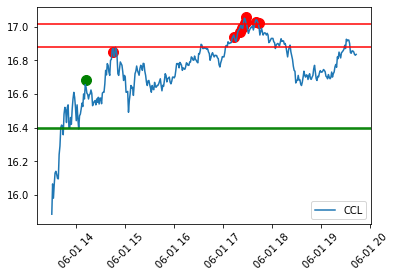

JWN analysis for run 1269 with profit 77.36


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-372.24,-372.24,buy,2020-06-01 14:14:03.206042,16.92,"[16.54, 16.61]",[18.175],22,"{'avg': 16.5048, 'rsi': 66.6136630599204, 'macd': [0.04660326343945087, 0.04425654514249544, 0.0538794120592101, 0.06957961363715981, 0.08108741129923303], 'vwap': 16.9196, 'supports': [16.54, 16.61], 'sell_macd': [0.025376366479122225, 0.023937546554353872, 0.03029771873564968, 0.040574505906324276, 0.04805545037819314], 'slow macd': [0.053088783552677654, 0.05310647271347335, 0.05543685130929177, 0.05925150694453052, 0.06266634764381607], 'macd_signal': [0.047024152089653916, 0.04647063070022222, 0.0479523869720198, 0.0522778323050478, 0.05803974810388485], 'resistances': [18.12], 'position_ratio': '3.58', 'sell_macd_signal': [0.02542801359953628, 0.0251299201904998, 0.026163479899529777, 0.029045685100888678, 0.03284763815634957]}",18.29,16.49
1,-3739.32,-3367.08,buy,2020-06-01 14:14:03.359056,16.92,"[16.54, 16.61]",[18.175],199,"{'avg': 16.5048, 'rsi': 66.6136630599204, 'macd': [0.04660326343945087, 0.04425654514249544, 0.0538794120592101, 0.06957961363715981, 0.08108741129923303], 'vwap': 16.9196, 'supports': [16.54, 16.61], 'sell_macd': [0.025376366479122225, 0.023937546554353872, 0.03029771873564968, 0.040574505906324276, 0.04805545037819314], 'slow macd': [0.053088783552677654, 0.05310647271347335, 0.05543685130929177, 0.05925150694453052, 0.06266634764381607], 'macd_signal': [0.047024152089653916, 0.04647063070022222, 0.0479523869720198, 0.0522778323050478, 0.05803974810388485], 'resistances': [18.12], 'position_ratio': '3.58', 'sell_macd_signal': [0.02542801359953628, 0.0251299201904998, 0.026163479899529777, 0.029045685100888678, 0.03284763815634957]}",18.29,16.49
2,-1840.72,1898.60,sell,2020-06-01 14:31:04.430256,17.26,None,None,110,"{'avg': 16.6359, 'rsi': [75.48235539092926, 77.3511076401296], 'vwap': 17.25, 'reasons': 'scale-out', 'movement': 0.020094562647754128, 'sell_macd': [0.07824986340132867, 0.07786963177248296, 0.07708153398672835, 0.07728455475124463, 0.0785169793112459], 'sell_macd_signal': [0.06996410354029828, 0.07154520918673521, 0.07265247414673384, 0.073578890267636, 0.07456650807635798]}",18.29,16.49
3,77.36,1918.08,sell,2020-06-01 14:31:49.119168,17.28,None,None,111,"{'avg': 16.6487, 'rsi': [77.77461626530334, 79.04079780454558], 'vwap': 17.2906, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.0023174971031285716, 'sell_macd': [0.07786963177248296, 0.07708153398672835, 0.07728455475124463, 0.07903645983072494, 0.08093357470005103], 'sell_macd_signal': [0.07154520918673521, 0.07265247414673384, 0.073578890267636, 0.0746704041802538, 0.07592303828421323]}",18.29,16.49


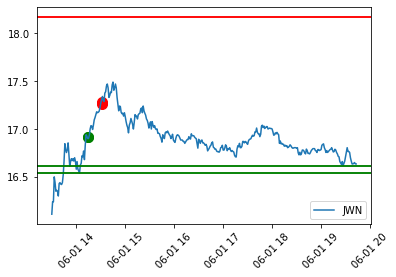

AR analysis for run 1269 with profit 33.84


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2681.82,-2681.82,buy,2020-06-01 14:27:27.725030,3.17,"[3.07, 3.11]","[3.25, 3.25, 3.27]",846,"{'avg': 3.1083, 'rsi': 66.1215337817207, 'macd': [0.010313652741560375, 0.01136839837032877, 0.011905667471268977, 0.013387508875466914, 0.014794791925759387], 'vwap': 3.17, 'supports': [2.99, 3.07, 3.11], 'sell_macd': [0.006471384286121484, 0.0071314226263679, 0.007449226234009565, 0.008379342990171956, 0.009255026917179165], 'slow macd': [0.005416956018962971, 0.005857538214743219, 0.006221532408918318, 0.006786372277435504, 0.007375157182812675], 'macd_signal': [0.004823665556161845, 0.00613261211899523, 0.00728722318944998, 0.008507280326653367, 0.009764782646474571], 'resistances': [3.27], 'position_ratio': '1.67', 'sell_macd_signal': [0.002863399453181999, 0.0037170040878191793, 0.0044634485170572565, 0.005246627411680196, 0.0060483073127799904]}",3.52,3.05
1,-1319.76,1362.06,sell,2020-06-01 17:24:11.187200,3.22,None,None,423,"{'avg': 3.1233, 'rsi': [67.82104056895943, 70.94656190672977], 'vwap': 3.22, 'reasons': 'scale-out', 'movement': 0.015772870662460654, 'sell_macd': [0.009471592758274472, 0.009871616449716125, 0.009826548982661443, 0.009502774995571173, 0.00951668130438943], 'sell_macd_signal': [0.007700042329721755, 0.008134357153720628, 0.008472795519508792, 0.008678791414721268, 0.0088463693926549]}",3.52,3.05
2,33.84,1353.60,sell,2020-06-01 19:36:50.178220,3.20,None,None,423,"{'avg': 3.1396, 'rsi': [72.06640196402464, 80.09214038562428], 'vwap': 3.21, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': -0.0031055900621118726, 'sell_macd': [0.0026797693492288666, 0.003287525889440701, 0.003978147532599952, 0.004345149494378919, 0.005473395834799], 'sell_macd_signal': [0.0028043818082170028, 0.0029010106244617426, 0.0031164380060893842, 0.0033621803037472914, 0.0037844234099576332]}",3.52,3.05


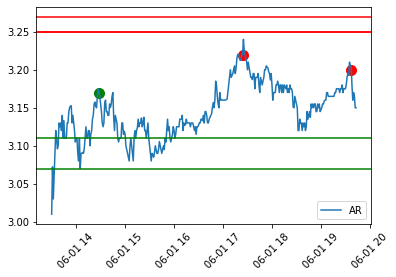

JBLU analysis for run 1269 with profit -111.91


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-6308.19,-6308.19,buy,2020-06-01 14:47:02.934289,10.71,"[10.5654, 10.615]",[10.9],589,"{'avg': 10.4607, 'rsi': 68.21697601296944, 'macd': [0.01618855007629172, 0.01769205333214252, 0.02145243846613276, 0.025350718118504645, 0.028116028750778455], 'vwap': 10.71, 'supports': [10.5654, 10.615], 'sell_macd': [0.008059688143879029, 0.009134909499454835, 0.011667096146664946, 0.014267928649079664, 0.016109253603570295], 'slow macd': [0.048507549606698674, 0.0481758813965687, 0.04835186217342091, 0.048676342108983306, 0.04889702302193477], 'macd_signal': [0.016719008005620754, 0.01691361707092511, 0.01782138134996664, 0.019327248703674242, 0.021085004713095084], 'resistances': [10.9], 'position_ratio': '2.0', 'sell_macd_signal': [0.007899239917065046, 0.008146373833543004, 0.008850518296167393, 0.009934000366749848, 0.011169051014113937]}",11.22,10.54
1,-111.91,6196.28,sell,2020-06-01 15:01:15.221085,10.52,None,None,589,"{'avg': 10.4867, 'rsi': [36.89421055716651, 34.576270559116686], 'vwap': 10.54, 'reasons': 'stopped', 'movement': -0.01587301587301603, 'sell_macd': [0.0036693615338290186, 5.6870945632780945e-05, -0.0020315226418663457, -0.006302588779632856, -0.010587801500236083], 'sell_macd_signal': [0.008781324008270601, 0.007036433395743037, 0.005222842188221161, 0.0029177559946503575, 0.0002166444956730692]}",11.22,10.54


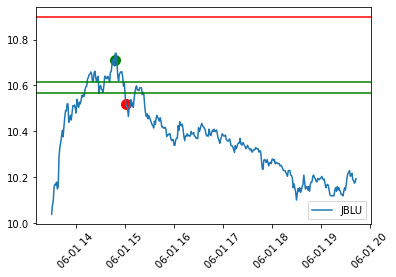

PLAY analysis for run 1269 with profit -115.44


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4314.96,-4314.96,buy,2020-06-01 14:43:19.024760,13.83,"[13.49, 13.5201, 13.6]","[14.2499, 14.32, 14.415]",312,"{'avg': 13.5179, 'rsi': 65.8682136634965, 'macd': [0.04440498277260474, 0.04798415028057512, 0.048646071829207216, 0.05339662493050845, 0.057315757702975034], 'vwap': 13.8301, 'supports': [13.49, 13.5201, 13.6], 'sell_macd': [0.027713131581265316, 0.029944666764714967, 0.030255672534094558, 0.03322196699680369, 0.03562658648726824], 'slow macd': [0.04250644006271109, 0.04365822490015958, 0.04432820651206093, 0.04583333040767812, 0.047306323915147885], 'macd_signal': [0.01928412118169371, 0.02502412700146999, 0.029748515967017435, 0.03447813775971564, 0.039045661748367516], 'resistances': [14.2499, 14.32, 14.415], 'position_ratio': '1.82', 'sell_macd_signal': [0.011110245688052797, 0.01487712990338523, 0.017952838429527097, 0.021006664142982415, 0.02393064861183958]}",14.79,13.51
1,-115.44,4199.52,sell,2020-06-01 15:04:14.439545,13.46,None,None,312,"{'avg': 13.566, 'rsi': [35.284271597526846, 34.062994307592106], 'vwap': 13.51, 'reasons': 'stopped', 'movement': -0.023138105567606673, 'sell_macd': [-0.003344964979813625, -0.013415637157383031, -0.022184789020977647, -0.029555754252077904, -0.03611552255875239], 'sell_macd_signal': [0.013182398123256066, 0.007862791067128247, 0.0018532750495070674, -0.004428530810809927, -0.01076592916039842]}",14.79,13.51


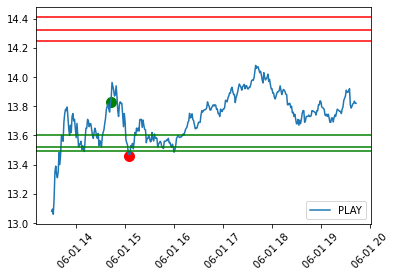

CLF analysis for run 1269 with profit 54.51


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-9811.80,-9811.80,buy,2020-06-01 14:26:52.120353,5.40,"[5.335, 5.345, 5.365]",[5.4045],1817,"{'avg': 5.341, 'rsi': 64.31718629716883, 'macd': [0.007018088892975172, 0.007556098761477337, 0.00808296006857745, 0.009201350436606859, 0.010371583910856685], 'vwap': 5.4002, 'supports': [5.205, 5.335, 5.345, 5.365], 'sell_macd': [0.0035864810679626657, 0.003966318190687268, 0.004335459868256564, 0.005086278579761405, 0.005865016814962765], 'slow macd': [0.01551044237993704, 0.015494227095227409, 0.01549291230974248, 0.015626859942432958, 0.015805071083197397], 'macd_signal': [0.00845610883772293, 0.008276106822473811, 0.00823747747169454, 0.008430252064677003, 0.00881851843391294], 'resistances': [5.52], 'position_ratio': '2.87', 'sell_macd_signal': [0.004409288185682205, 0.004320694186683217, 0.004323647322997887, 0.0044761735743505905, 0.004753942222473025]}",5.57,5.35
1,54.51,9866.31,sell,2020-06-01 14:39:58.198588,5.43,None,None,1817,"{'avg': 5.3574, 'rsi': [65.06766004495503, 64.8480277392275], 'vwap': 5.4304, 'reasons': 'bail', 'movement': 0.005629629629629503, 'sell_macd': [0.010041081329132062, 0.00963040848289598, 0.00949182693410311, 0.009296934468366658, 0.009008746385086752], 'sell_macd_signal': [0.00881453085485755, 0.008977706380465236, 0.00908053049119281, 0.00912381128662758, 0.009100798306319414]}",5.57,5.35


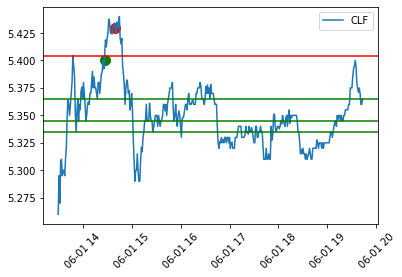

AMRS analysis for run 1269 with profit 4.55


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1983.80,-1983.80,buy,2020-06-01 14:37:54.119126,4.36,"[4.185, 4.29]",[4.46],455,"{'avg': 4.2369, 'rsi': 65.2041534814289, 'macd': [-0.017503864313280992, -0.0140829875362245, -0.007461126955496944, 0.00021310714000755127, 0.008608440324349154], 'vwap': 4.357, 'supports': [4.185, 4.29], 'sell_macd': [-0.013442696328730186, -0.010939610825144719, -0.006384744058387959, -0.0011889421095077068, 0.004428422293639045], 'slow macd': [0.05719188826402455, 0.0557682581502883, 0.05512737613337215, 0.05493098308040967, 0.055140649474976655], 'macd_signal': [-0.015733918389069713, -0.01540373221850067, -0.013815211165899925, -0.01100954750471843, -0.007085949938904913], 'resistances': [4.46], 'position_ratio': '1.43', 'sell_macd_signal': [-0.013702288800736914, -0.013149753205618476, -0.011796751376172372, -0.009675189522839439, -0.006854467159543742]}",5.02,4.14
1,4.55,1988.35,sell,2020-06-01 15:29:40.231414,4.37,None,None,455,"{'avg': 4.2435, 'rsi': [73.33456387837079, 80.55009532503135], 'vwap': 4.38, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.0045871559633026545, 'sell_macd': [0.014788461816611864, 0.01591840163566971, 0.01685188199291421, 0.01762015393371552, 0.02058737682351275], 'sell_macd_signal': [0.006907911841971167, 0.008710009800710876, 0.010338384239151541, 0.011794738178064337, 0.013553265907154019]}",5.02,4.14


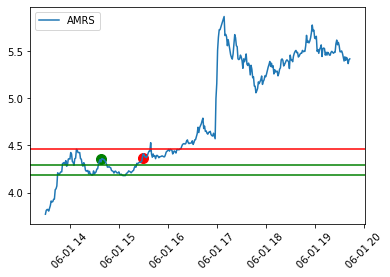

MTG analysis for run 1270 with profit 69.58


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-7534.23,-7534.23,buy,2020-06-01 14:36:08.572837,8.67,"[8.575, 8.5801]","[8.785, 8.87, 8.87, 8.87]",869,"{'avg': 8.5587, 'rsi': 67.16219752480438, 'macd': [0.009983906391905606, 0.012059049902736874, 0.012749728722871723, 0.013544423197647149, 0.016804717464804497], 'vwap': 8.6691, 'supports': [8.205, 8.205, 8.21, 8.27, 8.575, 8.5801], 'sell_macd': [0.0046147406544463365, 0.006050831595665329, 0.006571800749918921, 0.007152142938299022, 0.009329654475498828], 'slow macd': [0.03748686397203471, 0.03732114847677437, 0.03694905893319067, 0.03662759780743485, 0.036833038654457084], 'macd_signal': [0.011302629648721509, 0.011453913699524582, 0.01171307670419401, 0.012079346002884638, 0.01302442029526861], 'resistances': [8.785, 8.87, 8.87, 8.87], 'position_ratio': '1.16', 'sell_macd_signal': [0.00505751596117852, 0.005256179088075881, 0.00551930342044449, 0.005845871324015396, 0.006542627954312082]}",9.02,8.56
1,-3745.41,3788.82,sell,2020-06-01 15:14:47.451223,8.73,None,None,434,"{'avg': 8.5943, 'rsi': [63.311624162369014, 65.7387529760829], 'vwap': 8.73, 'reasons': 'scale-out', 'movement': 0.006920415224913552, 'sell_macd': [0.0014922424805359213, 0.0013914987929055656, 0.003632588142897575, 0.006110935842333021, 0.008741973843941153], 'sell_macd_signal': [0.003939650652015081, 0.003430020280193178, 0.0034705338527340574, 0.00399861425065385, 0.004947286169311311]}",9.02,8.56
2,-1844.49,1900.92,sell,2020-06-01 15:18:53.999857,8.76,None,None,217,"{'avg': 8.5984, 'rsi': [62.586374927011605, 66.46074933714587], 'vwap': 8.7603, 'reasons': 'scale-out', 'movement': 0.0034364261168384146, 'sell_macd': [0.008747168649136938, 0.011721542671981666, 0.014406489408328227, 0.015012857132646218, 0.01658908059143016], 'sell_macd_signal': [0.004948325130350468, 0.006302968638676708, 0.007923672792607011, 0.009341509660614852, 0.010791023846777914]}",9.02,8.56
3,-887.47,957.02,sell,2020-06-01 15:57:38.251268,8.78,None,None,109,"{'avg': 8.6291, 'rsi': [62.531248456499576, 71.21710491485076], 'vwap': 8.7732, 'reasons': 'scale-out', 'movement': 0.0022831050228310015, 'sell_macd': [0.006315595267922802, 0.00626537082237455, 0.006404606698280801, 0.006429925475632814, 0.007664850166094084], 'sell_macd_signal': [0.004878591743033652, 0.005155947558901831, 0.005405679386777626, 0.005610528604548663, 0.006021392916857747]}",9.02,8.56
4,-413.35,474.12,sell,2020-06-01 15:57:40.091405,8.78,None,None,54,"{'avg': 8.6293, 'rsi': [62.531248456499576, 72.49244331826755], 'vwap': 8.7769, 'reasons': 'scale-out', 'movement': 0.0005694760820046449, 'sell_macd': [0.006315595267922802, 0.00626537082237455, 0.006404606698280801, 0.006429925475632814, 0.0079245904258336], 'sell_macd_signal': [0.004878591743033652, 0.005155947558901831, 0.005405679386777626, 0.005610528604548663, 0.00607334096880565]}",9.02,8.56
5,-176.29,237.06,sell,2020-06-01 15:57:45.037443,8.78,None,None,27,"{'avg': 8.6293, 'rsi': [62.531248456499576, 72.49244331826755], 'vwap': 8.7805, 'reasons': 'scale-out', 'movement': 0.0005694760820046449, 'sell_macd': [0.006315595267922802, 0.00626537082237455, 0.006404606698280801, 0.006429925475632814, 0.0079245904258336], 'sell_macd_signal': [0.004878591743033652, 0.005155947558901831, 0.005405679386777626, 0.005610528604548663, 0.00607334096880565]}",9.02,8.56
6,-53.37,122.92,sell,2020-06-01 15:58:07.228926,8.78,None,None,14,"{'avg': 8.6294, 'rsi': [71.21710491485076, 72.58588096772586], 'vwap': 8.7826, 'reasons': 'scale-out', 'movement': 0.0005694760820046449, 'sell_macd': [0.00626537082237455, 0.006404606698280801, 0.006429925475632814, 0.007664850166094084, 0.008787325896763676], 'sell_macd_signal': [0.005155947558901831, 0.005405679386777626, 0.005610528604548663, 0.006021392916857747, 0.006574579512838933]}",9.02,8.56
7,8.09,61.46,sell,2020-06-01 15:58:08.045159,8.78,None,None,7,"{'avg': 8.6294, 'rsi': [71.21710491485076, 72.58588096772586], 'vwap': 8.785, 'reas

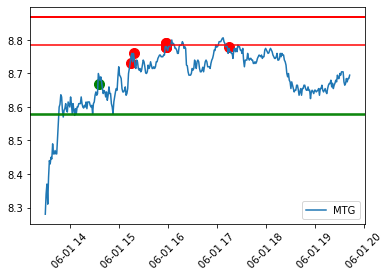

SVC analysis for run 1270 with profit -26.35


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-7704.74,-7704.74,buy,2020-06-01 14:39:25.718471,7.31,"[7.095, 7.205, 7.23]",[7.4],1054,"{'avg': 7.1055, 'rsi': 66.25784414033602, 'macd': [0.016650647204926372, 0.017980871594760472, 0.019217020372040317, 0.020365376019515935, 0.023426163196090144], 'vwap': 7.3107, 'supports': [6.67, 6.74, 7.095, 7.205, 7.23], 'sell_macd': [0.007637481620111686, 0.008625528512686387, 0.009543155591151375, 0.010393992852407052, 0.012480437564393654], 'slow macd': [0.04787051726136493, 0.047598038739006476, 0.0473511913839868, 0.047128320320638295, 0.047327704727655906], 'macd_signal': [0.025292365213978478, 0.023830066490134878, 0.022907457266515965, 0.02239904101711596, 0.022604465452910796], 'resistances': [7.4], 'position_ratio': '1.0', 'sell_macd_signal': [0.012886742465058333, 0.012034499674583945, 0.011536230857897432, 0.011307783256799356, 0.011542314118318216]}",7.6,7.21
1,-7210.95,493.79,sell,2020-06-01 14:45:40.008298,7.37,None,None,67,"{'avg': 7.1111, 'rsi': [64.82540167675442, 67.42932318210786], 'vwap': 7.36, 'reasons': 'scale-out', 'movement': 0.006839945280437854, 'sell_macd': [0.011688249039314869, 0.013346071225156741, 0.01420481486055003, 0.015728448669161565, 0.017750391264584664], 'sell_macd_signal': [0.012092317894165639, 0.01234306856036386, 0.012715417820401094, 0.013318023990153189, 0.014204497445039484]}",7.6,7.21
2,-3820.75,3390.20,sell,2020-06-01 14:45:40.182525,7.37,None,None,460,"{'avg': 7.1111, 'rsi': [64.82540167675442, 67.42932318210786], 'vwap': 7.36, 'reasons': 'scale-out', 'movement': 0.006839945280437854, 'sell_macd': [0.011688249039314869, 0.013346071225156741, 0.01420481486055003, 0.015728448669161565, 0.017750391264584664], 'sell_macd_signal': [0.012092317894165639, 0.01234306856036386, 0.012715417820401094, 0.013318023990153189, 0.014204497445039484]}",7.6,7.21
3,-2567.95,1252.80,sell,2020-06-01 15:05:05.167910,7.20,None,None,174,"{'avg': 7.1441, 'rsi': [39.09846285562264, 33.44039828796172], 'vwap': 7.21, 'reasons': 'stopped', 'movement': -0.021709633649932177, 'sell_macd': [0.002901516003091409, -0.0012150807108959327, -0.004407038141135189, -0.006837043435592882, -0.010719683360681742], 'sell_macd_signal': [0.010492799570747646, 0.00815122351441893, 0.005639571183308106, 0.0031442482595279084, 0.0003714619354859782]}",7.6,7.21
4,-26.35,2541.60,sell,2020-06-01 15:05:05.367041,7.20,None,None,353,"{'avg': 7.1441, 'rsi': [39.09846285562264, 33.44039828796172], 'vwap': 7.21, 'reasons': 'stopped', 'movement': -0.021709633649932177, 'sell_macd': [0.002901516003091409, -0.0012150807108959327, -0.004407038141135189, -0.006837043435592882, -0.010719683360681742], 'sell_macd_signal': [0.010492799570747646, 0.00815122351441893, 0.005639571183308106, 0.0031442482595279084, 0.0003714619354859782]}",7.6,7.21


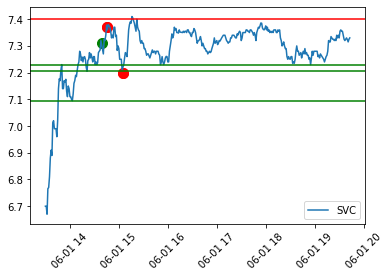

HWM analysis for run 1270 with profit 45.9


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-5422.41,-5422.41,buy,2020-06-01 14:22:55.665248,13.59,"[13.38, 13.39, 13.4]",[13.7484],399,"{'avg': 13.3666, 'rsi': 63.66339192461389, 'macd': [0.032479263812440706, 0.03462728238070589, 0.034719008810194296, 0.03718723881836716, 0.04069155305476002], 'vwap': 13.59, 'supports': [12.96, 13.025, 13.095, 13.38, 13.39, 13.4], 'sell_macd': [0.018071689372257893, 0.019524324442821595, 0.019623464440106986, 0.021264048016693238, 0.02356496966056909], 'slow macd': [0.052789304235027146, 0.05308756641909618, 0.053037166986815265, 0.05346574844958063, 0.05417438617530124], 'macd_signal': [0.02921743497725237, 0.030299404457943074, 0.031183325328393317, 0.03238410802638809, 0.034045597032062475], 'resistances': [13.7484], 'position_ratio': '0.83', 'sell_macd_signal': [0.015522739134072506, 0.016323056195822323, 0.016983137844679256, 0.017839319879082053, 0.01898444983537946]}",14.34,13.34
1,-3232.01,2190.40,sell,2020-06-01 14:26:15.186719,13.69,None,None,160,"{'avg': 13.373, 'rsi': [65.5307284997851, 69.24282035935987], 'vwap': 13.6875, 'reasons': 'scale-out', 'movement': 0.00735835172921263, 'sell_macd': [0.02356496966056909, 0.02816874016669857, 0.029831824455024858, 0.03177926903742012, 0.0354814431400996], 'sell_macd_signal': [0.01898444983537946, 0.02082130790164328, 0.022623411212319595, 0.024454582777339702, 0.02665995484989168]}",14.34,13.34
2,-2698.10,533.91,sell,2020-06-01 14:26:15.877964,13.69,None,None,39,"{'avg': 13.373, 'rsi': [65.5307284997851, 69.24282035935987], 'vwap': 13.6875, 'reasons': 'scale-out', 'movement': 0.00735835172921263, 'sell_macd': [0.02356496966056909, 0.02816874016669857, 0.029831824455024858, 0.03177926903742012, 0.0354814431400996], 'sell_macd_signal': [0.01898444983537946, 0.02082130790164328, 0.022623411212319595, 0.024454582777339702, 0.02665995484989168]}",14.34,13.34
3,-1326.10,1372.00,sell,2020-06-01 14:39:36.116264,13.72,None,None,100,"{'avg': 13.4018, 'rsi': [63.398876076729806, 65.52726500839044], 'vwap': 13.72, 'reasons': 'scale-out', 'movement': 0.0021913805697590313, 'sell_macd': [0.027501076747569186, 0.029000746691437485, 0.029538142145211665, 0.029048604289124924, 0.02932885265724927], 'sell_macd_signal': [0.03131467699613706, 0.030851890935197145, 0.03058914117720005, 0.030281033799585026, 0.030090597571117875]}",14.34,13.34
4,45.90,1372.00,sell,2020-06-01 14:42:39.077516,13.72,None,None,100,"{'avg': 13.4062, 'rsi': [64.53755014170592, 65.7118005206357], 'vwap': 13.7312, 'reasons': 'bail', 'movement': 0.0007288629737609173, 'sell_macd': [0.029048604289124924, 0.02984833317673008, 0.029564377333608505, 0.02895916008788113, 0.028630949765393154], 'sell_macd_signal': [0.030281033799585026, 0.030194493675014037, 0.030068470406732932, 0.02984660834296257, 0.029603476627448687]}",14.34,13.34


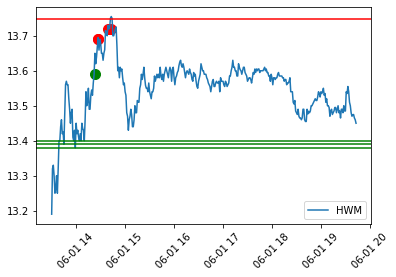

SM analysis for run 1270 with profit -77.22


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2903.04,-2903.04,buy,2020-06-01 14:16:45.770379,3.78,"[3.652, 3.67]",[3.89],768,"{'avg': 3.6656, 'rsi': 68.02693999642067, 'macd': [0.020018084260197355, 0.01927823588781985, 0.02230794743780562, 0.024427431444913328, 0.0266073413485457], 'vwap': 3.7695, 'supports': [3.5, 3.67], 'sell_macd': [0.011784985549405658, 0.011286151323735005, 0.013244382429397739, 0.014598271830831067, 0.015983143158820656], 'slow macd': [0.013909614319114638, 0.01415869320261498, 0.015132901814419952, 0.016005001937772878, 0.01694170020889807], 'macd_signal': [0.016137686467642604, 0.016765796351678054, 0.017874226568903567, 0.01918486754410552, 0.020669362304993555], 'resistances': [3.92], 'position_ratio': '1.27', 'sell_macd_signal': [0.00928960402805005, 0.009688913487187041, 0.01040000727562918, 0.011239660186669557, 0.012188356781099776]}",4.17,3.65
1,23.04,2926.08,sell,2020-06-01 14:31:07.394580,3.81,None,None,768,"{'avg': 3.6932, 'rsi': [65.80059057787483, 65.80059057787484], 'vwap': 3.8142, 'reasons': 'bail', 'movement': 0.009259259259259297, 'sell_macd': [0.015377869135471567, 0.014606301885934592, 0.015373829978686082, 0.015512503427859592, 0.015419099577503204], 'sell_macd_signal': [0.015659177048318245, 0.015448602015841514, 0.015433647608410428, 0.015449418772300261, 0.01544335493334085]}",4.17,3.65
2,-4265.86,-4288.90,buy,2020-06-01 14:46:13.550945,3.85,"[3.652, 3.67, 3.78, 3.812]",[3.89],1114,"{'avg': 3.7117, 'rsi': 67.33826492017381, 'macd': [0.017815886873942866, 0.017509414709969473, 0.018266344898195452, 0.019050078294689854, 0.019845879921063236], 'vwap': 3.85, 'supports': [3.67, 3.78, 3.812], 'sell_macd': [0.009782214353851515, 0.009605334377999597, 0.01012198200229708, 0.010652850514706547, 0.011187905842367396], 'slow macd': [0.024686802852467604, 0.024685358744910513, 0.024884453376470717, 0.025107795613061423, 0.025353089217197144], 'macd_signal': [0.020366858299635613, 0.019795369581702384, 0.019489564645000998, 0.01940166737493877, 0.019490509884163662], 'resistances': [3.92, 4.0, 4.015], 'position_ratio': '1.84', 'sell_macd_signal': [0.01141229522056749, 0.011050903052053912, 0.010865118842102546, 0.010822665176623347, 0.010895713309772157]}",4.12,3.76
3,-77.22,4188.64,sell,2020-06-01 15:04:53.972380,3.76,None,None,1114,"{'avg': 3.7286, 'rsi': [37.98068382843225, 35.37439578474873], 'vwap': 3.7602, 'reasons': 'stopped', 'movement': -0.023376623376623454, 'sell_macd': [-6.88096334053867e-05, -0.0017358895402539432, -0.0030123688242884583, -0.0044821920478961275, -0.006093973883851245], 'sell_macd_signal': [0.002495718982239966, 0.0016493972777411841, 0.0007170440573352555, -0.00032280316371102106, -0.0014770373077390658]}",4.12,3.76


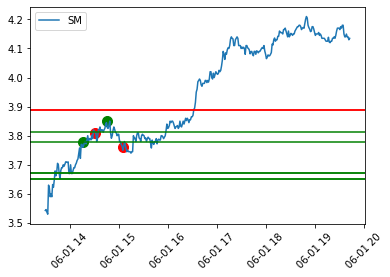

DFEN analysis for run 1270 with profit -112.7


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4520.88,-4520.88,buy,2020-06-01 14:26:50.470021,14.04,"[13.7645, 13.9]",[14.04],322,"{'avg': 13.807, 'rsi': 67.24810579676007, 'macd': [0.04813404701195623, 0.04929451323657119, 0.04964194958649415, 0.05174159972291292, 0.05357874328024437], 'vwap': 14.0521, 'supports': [13.7645, 13.9], 'sell_macd': [0.025566299206969845, 0.026453249568019643, 0.026800831023797045, 0.028282052534484237, 0.029578042639766267], 'slow macd': [0.08727311305603358, 0.087136418599151, 0.08687129280159667, 0.08696823817089694, 0.08707507477308596], 'macd_signal': [0.05539197802664765, 0.054172485068632356, 0.053266377972204716, 0.05296142232234636, 0.05308488651392596], 'resistances': [14.385], 'position_ratio': '2.24', 'sell_macd_signal': [0.02983565581017636, 0.029159174561745015, 0.028687505854155422, 0.028606415190221186, 0.0288007406801302]}",14.98,13.74
1,-2481.07,2039.81,sell,2020-06-01 15:04:14.458628,13.69,None,None,149,"{'avg': 13.8366, 'rsi': [26.98033113875763, 23.340492666066474], 'vwap': 13.6962, 'reasons': 'stopped', 'movement': -0.024928774928774905, 'sell_macd': [-0.019004160232920952, -0.024481379134266845, -0.028950882445261783, -0.03335632811038458, -0.03921308670514989], 'sell_macd_signal': [-0.007783161736774381, -0.011122805216272874, -0.014688420662070656, -0.01842200215173344, -0.02258021906241673]}",14.98,13.74
2,-112.70,2368.37,sell,2020-06-01 15:04:15.175295,13.69,None,None,173,"{'avg': 13.8366, 'rsi': [26.98033113875763, 23.340492666066474], 'vwap': 13.6962, 'reasons': 'stopped', 'movement': -0.024928774928774905, 'sell_macd': [-0.019004160232920952, -0.024481379134266845, -0.028950882445261783, -0.03335632811038458, -0.03921308670514989], 'sell_macd_signal': [-0.007783161736774381, -0.011122805216272874, -0.014688420662070656, -0.01842200215173344, -0.02258021906241673]}",14.98,13.74


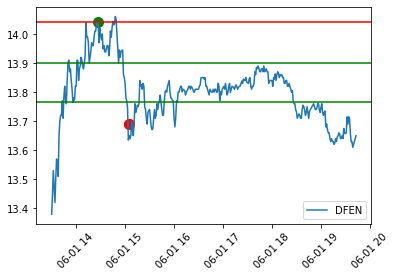

XRX analysis for run 1270 with profit 95.68


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-6851.52,-6851.52,buy,2020-06-01 14:13:05.954977,16.47,[16.24],"[17.27, 17.28]",416,"{'avg': 16.213, 'rsi': 65.67350188329026, 'macd': [0.039900285355845, 0.04427619928416959, 0.04720004980596926, 0.049750644376540976, 0.05277745614121798], 'vwap': 16.4696, 'supports': [15.85, 15.86, 16.24], 'sell_macd': [0.021674575539929464, 0.024580174497430107, 0.026525054535778025, 0.028215544766492684, 0.030205335273979728], 'slow macd': [0.03878524582160736, 0.04027298050796091, 0.04157733300347033, 0.04287081791357039, 0.04431217157469902], 'macd_signal': [0.046998281161809916, 0.04645386478628185, 0.04660310179021933, 0.04723261030748366, 0.048341579474230525], 'resistances': [17.27, 17.28, 17.33], 'position_ratio': '3.48', 'sell_macd_signal': [0.02642328794431868, 0.026054665254940965, 0.026148743111108378, 0.02656210344218524, 0.027290749808544137]}",17.19,16.22
1,-422.02,6429.50,sell,2020-06-01 14:36:44.967593,16.70,None,None,385,"{'avg': 16.299, 'rsi': [78.24935655306001, 79.03217397018253], 'vwap': 16.7005, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.013964784456587762, 'sell_macd': [0.03482848055882215, 0.032393919882348854, 0.031115120395718066, 0.03387040494644822, 0.03609698505161063], 'sell_macd_signal': [0.03684188830582396, 0.035952294621128936, 0.03498485977604676, 0.03476196881012705, 0.03502897205842377]}",17.19,16.22
2,95.68,517.70,sell,2020-06-01 14:36:45.206433,16.70,None,None,31,"{'avg': 16.299, 'rsi': [78.24935655306001, 79.03217397018253], 'vwap': 16.7005, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.013964784456587762, 'sell_macd': [0.03482848055882215, 0.032393919882348854, 0.031115120395718066, 0.03387040494644822, 0.03609698505161063], 'sell_macd_signal': [0.03684188830582396, 0.035952294621128936, 0.03498485977604676, 0.03476196881012705, 0.03502897205842377]}",17.19,16.22


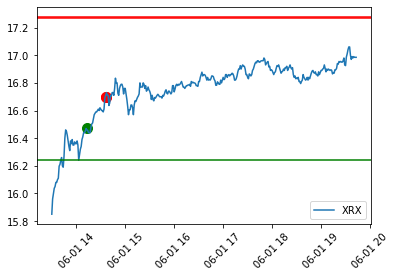

CIT analysis for run 1270 with profit -9.18


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-984.30,-984.30,buy,2020-06-01 14:39:24.868903,19.30,[19.0908],"[19.74, 20.02]",51,"{'avg': 18.5619, 'rsi': 67.15742421750627, 'macd': [0.06874892572735547, 0.0770710136192001, 0.07952198261002863, 0.0853223488266579, 0.0882243753630334], 'vwap': 19.3016, 'supports': [18.09, 19.0908], 'sell_macd': [0.0373765590252404, 0.04291149121808857, 0.04458921122266801, 0.04843432796360503, 0.05036514194403097], 'slow macd': [0.10171009680729881, 0.10345796266669893, 0.10426084451068718, 0.10579238699168414, 0.10689790866333837], 'macd_signal': [0.07913946751253474, 0.07872577673386781, 0.07888501790909998, 0.08017248409261156, 0.08178286234669593], 'resistances': [19.74, 20.02], 'position_ratio': '2.08', 'sell_macd_signal': [0.0439004997165421, 0.04370269801685139, 0.043880000658014714, 0.04479086611913278, 0.04590572128411242]}",21.26,18.65
1,-2952.90,-1968.60,buy,2020-06-01 14:39:25.065719,19.30,[19.0908],"[19.74, 20.02]",102,"{'avg': 18.5619, 'rsi': 67.15742421750627, 'macd': [0.06874892572735547, 0.0770710136192001, 0.07952198261002863, 0.0853223488266579, 0.0882243753630334], 'vwap': 19.3016, 'supports': [18.09, 19.0908], 'sell_macd': [0.0373765590252404, 0.04291149121808857, 0.04458921122266801, 0.04843432796360503, 0.05036514194403097], 'slow macd': [0.10171009680729881, 0.10345796266669893, 0.10426084451068718, 0.10579238699168414, 0.10689790866333837], 'macd_signal': [0.07913946751253474, 0.07872577673386781, 0.07888501790909998, 0.08017248409261156, 0.08178286234669593], 'resistances': [19.74, 20.02], 'position_ratio': '2.08', 'sell_macd_signal': [0.0439004997165421, 0.04370269801685139, 0.043880000658014714, 0.04479086611913278, 0.04590572128411242]}",21.26,18.65
2,-9.18,2943.72,sell,2020-06-01 17:21:27.545073,19.24,None,None,153,"{'avg': 18.7757, 'rsi': [78.88499875684688, 79.67271045261637], 'vwap': 19.25, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': -0.00259067357512957, 'sell_macd': [0.02358702828013648, 0.02552589932086491, 0.028523384556226716, 0.032047095329804876, 0.03489612846077961], 'sell_macd_signal': [0.0199575199122976, 0.02107119579401106, 0.022561633546454192, 0.02445872590312433, 0.026546206414655386]}",21.26,18.65


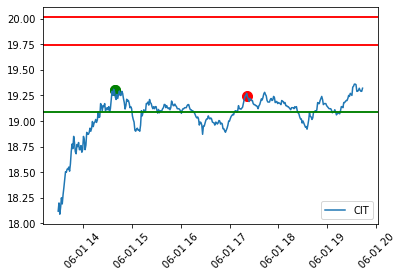

BCS analysis for run 1270 with profit -127.32


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-12668.34,-12668.34,buy,2020-06-01 14:55:37.983437,5.97,[5.935],[6.02],2122,"{'avg': 5.8858, 'rsi': 68.89081067688413, 'macd': [0.004928775392243345, 0.004151953782900897, 0.0046925983478560696, 0.005860424165438971, 0.0075063227499789775], 'vwap': 5.9602, 'supports': [5.65, 5.805, 5.87, 5.92, 5.935], 'sell_macd': [0.002375557344131529, 0.0019003543069660012, 0.0022846070792139628, 0.00307383512149606, 0.0041683785944233165], 'slow macd': [0.019903091940581596, 0.019408524299234564, 0.019162369065353957, 0.019065186870463435, 0.019105220066015782], 'macd_signal': [0.006532092935514702, 0.006056065104991941, 0.005783371753564767, 0.005798782235939608, 0.006140290338747482], 'resistances': [6.02, 6.02, 6.02], 'position_ratio': '1.43', 'sell_macd_signal': [0.003296669326512268, 0.003017406322603015, 0.0028708464739252045, 0.0029114442034393756, 0.0031628310816361636]}",6.11,5.92
1,-127.32,12541.02,sell,2020-06-01 15:04:29.079431,5.91,None,None,2122,"{'avg': 5.8954, 'rsi': [37.419273449983336, 33.3545361609938], 'vwap': 5.9101, 'reasons': 'stopped', 'movement': -0.010033500837520913, 'sell_macd': [0.002976433840594872, 0.0020509539729127724, 0.0009603079205255938, -0.0004214981971850662, -0.002007041948685284], 'sell_macd_signal': [0.0035247220690484177, 0.0032299684498212885, 0.0027760363439621495, 0.0021365294357327063, 0.001307815158849108]}",6.11,5.92


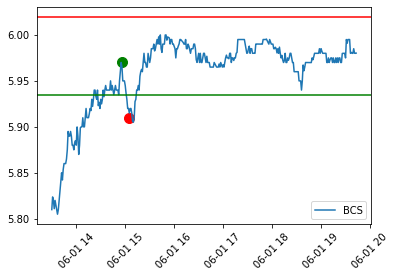

CNSL analysis for run 1273 with profit 24.96


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3999.84,-3999.84,buy,2020-06-01 14:26:13.044023,6.41,"[6.26, 6.3]",[6.465],624,"{'avg': 6.2659, 'rsi': 63.89507809047799, 'macd': [0.0295552501827947, 0.029099972536926977, 0.029209370705698845, 0.029759931997975997, 0.03064985971132117], 'vwap': 6.42, 'supports': [5.91, 6.0, 6.0, 6.0, 6.06, 6.26, 6.3], 'sell_macd': [0.016104798615093507, 0.015864377452913025, 0.015990485931046017, 0.016400564148669083, 0.01702659179683419], 'slow macd': [0.04611458332249363, 0.04598399470562864, 0.04595024005299919, 0.04600562973076183, 0.0461429464559151], 'macd_signal': [0.031596085827826643, 0.03109686316964671, 0.030719364676857135, 0.030527478141080908, 0.03055195445512896], 'resistances': [6.57, 6.6115, 6.64, 6.68, 6.68], 'position_ratio': '1.25', 'sell_macd_signal': [0.017211572868297314, 0.016942133785220456, 0.016751804214385567, 0.01668155620124227, 0.016750563320360654]}",6.9,6.26
1,24.96,4024.80,sell,2020-06-01 14:43:08.826339,6.45,None,None,624,"{'avg': 6.2941, 'rsi': [63.46331715690698, 64.20717401905564], 'vwap': 6.4534, 'reasons': 'bail', 'movement': 0.006786271450858014, 'sell_macd': [0.0166570219375064, 0.015632886832015025, 0.014839627180567305, 0.014600208917354252, 0.014405854310728827], 'sell_macd_signal': [0.01796941074040148, 0.01750210595872419, 0.016969610203092813, 0.0164957299459451, 0.016077754818901845]}",6.9,6.26


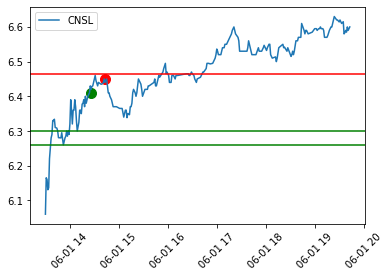

VVI analysis for run 1273 with profit -118.91


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4920.85,-4920.85,buy,2020-06-01 14:40:01.652109,19.45,[19.065],"[20.21, 20.51, 20.87]",253,"{'avg': 18.959, 'rsi': 68.25238962796799, 'macd': [0.03822690214314761, 0.04197166837645128, 0.056393104389705684, 0.06465613141559245, 0.07996584055079836], 'vwap': 19.4126, 'supports': [18.16, 18.181, 18.5375, 19.065], 'sell_macd': [0.018285274263334372, 0.02094813206176127, 0.030543240319470755, 0.03606484103561769, 0.046132778723062984], 'slow macd': [0.08637045603728666, 0.08648565678544884, 0.08885236382038642, 0.09040789498076407, 0.09361367091842965], 'macd_signal': [0.05542829692793737, 0.05273697121764015, 0.053468197852053256, 0.05570578456476109, 0.06055779576196855], 'resistances': [20.21], 'position_ratio': '1.97', 'sell_macd_signal': [0.028904503867622177, 0.027313229506449994, 0.027959231669054146, 0.029580353542366856, 0.03289083857850608]}",20.63,19.05
1,-118.91,4801.94,sell,2020-06-01 15:57:14.423892,18.98,None,None,253,"{'avg': 19.1697, 'rsi': [38.970219246383934, 30.622712758230946], 'vwap': 19.0454, 'reasons': 'stopped', 'movement': -0.022107969151670938, 'sell_macd': [0.0010395845841557616, -0.0029587232698453647, -0.014861836879845214, -0.02186605739569103, -0.03742952718212322], 'sell_macd_signal': [0.009947610315436665, 0.007366343598380259, 0.002920707502735165, -0.002036645476950074, -0.009115221817984704]}",20.63,19.05


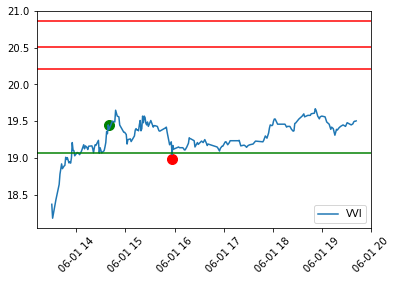

DRH analysis for run 1271 with profit -26.64


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2789.60,-2789.60,buy,2020-06-01 14:12:24.550314,6.34,[6.22],[6.46],440,"{'avg': 6.2088, 'rsi': 66.81780050127037, 'macd': [0.03200904434271212, 0.03101439520409066, 0.03147711288518096, 0.0334752294400511, 0.0358558024737512], 'vwap': 6.34, 'supports': [5.91, 5.955, 5.965, 6.08, 6.13, 6.22], 'sell_macd': [0.017663866960321073, 0.01703963101536221, 0.017370880525584553, 0.01870210247477555, 0.02027575461083675], 'slow macd': [0.033466963390922366, 0.03367256875187774, 0.034127749743701585, 0.034891788313558436, 0.03577882773618413], 'macd_signal': [0.038511071113257536, 0.037011735931424164, 0.035904811322175524, 0.03541889494575064, 0.03550627645135075], 'resistances': [6.46, 6.67, 6.68], 'position_ratio': '1.0', 'sell_macd_signal': [0.02205375797195609, 0.021050932580637314, 0.020314922169626763, 0.01999235823065652, 0.020049037506692565]}",6.79,6.19
1,-4222.44,-1432.84,buy,2020-06-01 14:12:24.864946,6.34,[6.22],[6.46],226,"{'avg': 6.2088, 'rsi': 66.81780050127037, 'macd': [0.03200904434271212, 0.03101439520409066, 0.03147711288518096, 0.0334752294400511, 0.0358558024737512], 'vwap': 6.34, 'supports': [5.91, 5.955, 5.965, 6.08, 6.13, 6.22], 'sell_macd': [0.017663866960321073, 0.01703963101536221, 0.017370880525584553, 0.01870210247477555, 0.02027575461083675], 'slow macd': [0.033466963390922366, 0.03367256875187774, 0.034127749743701585, 0.034891788313558436, 0.03577882773618413], 'macd_signal': [0.038511071113257536, 0.037011735931424164, 0.035904811322175524, 0.03541889494575064, 0.03550627645135075], 'resistances': [6.46, 6.67, 6.68], 'position_ratio': '1.0', 'sell_macd_signal': [0.02205375797195609, 0.021050932580637314, 0.020314922169626763, 0.01999235823065652, 0.020049037506692565]}",6.79,6.19
2,-2087.91,2134.53,sell,2020-06-01 14:50:55.910911,6.41,None,None,333,"{'avg': 6.2404, 'rsi': [67.50229185885662, 70.93364034795681], 'vwap': 6.4003, 'reasons': 'scale-out', 'movement': 0.011041009463722443, 'sell_macd': [0.013737023792547376, 0.014310793095159369, 0.016130473160894, 0.016975282651584322, 0.01855597468781589], 'sell_macd_signal': [0.011041459972831668, 0.011695326597297207, 0.012582355910016566, 0.013460941258330117, 0.014479947944227271]}",6.79,6.19
3,-26.64,2061.27,sell,2020-06-01 18:12:09.176799,6.19,None,None,333,"{'avg': 6.2646, 'rsi': [19.123576243803555, 15.801732893282738], 'vwap': 6.199, 'reasons': 'stopped', 'movement': -0.034321372854914156, 'sell_macd': [-0.00434014824573925, -0.006008441906669049, -0.007490119539774298, -0.009586360298819763, -0.012134257509780255], 'sell_macd_signal': [0.000584829667680669, -0.0007338246471892745, -0.002085083625706279, -0.0035853389603289756, -0.005295122670219232]}",6.79,6.19


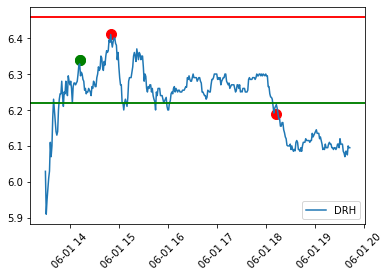

OIS analysis for run 1271 with profit -106.8


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2300.65,-2300.65,buy,2020-06-01 14:38:57.835236,4.45,"[4.37, 4.4]",[4.45],517,"{'avg': 4.3355, 'rsi': 69.20679376030694, 'macd': [0.01094599735616697, 0.011700451376506216, 0.013969035564789678, 0.01558722505059773, 0.01747512592921563], 'vwap': 4.455, 'supports': [4.2, 4.23, 4.24, 4.31, 4.31, 4.37, 4.4], 'sell_macd': [0.006309853881626637, 0.0067928980613460865, 0.008260297447344023, 0.00929644895010373, 0.010502587147707132], 'slow macd': [0.012922357432445963, 0.01315275665867599, 0.013706750098468667, 0.014194519752434687, 0.014780517311318242], 'macd_signal': [0.012177897732036832, 0.01208240846093071, 0.012459733881702503, 0.013085232115481548, 0.013963210878228365], 'resistances': [4.52, 4.54, 4.585], 'position_ratio': '1.18', 'sell_macd_signal': [0.0071781557544430535, 0.00710110421582366, 0.007332942862127732, 0.007725644079722932, 0.008281032693319772]}",4.68,4.38
1,-5940.75,-3640.10,buy,2020-06-01 14:38:58.050039,4.45,"[4.37, 4.4]",[4.45],818,"{'avg': 4.3355, 'rsi': 69.20679376030694, 'macd': [0.01094599735616697, 0.011700451376506216, 0.013969035564789678, 0.01558722505059773, 0.01747512592921563], 'vwap': 4.455, 'supports': [4.2, 4.23, 4.24, 4.31, 4.31, 4.37, 4.4], 'sell_macd': [0.006309853881626637, 0.0067928980613460865, 0.008260297447344023, 0.00929644895010373, 0.010502587147707132], 'slow macd': [0.012922357432445963, 0.01315275665867599, 0.013706750098468667, 0.014194519752434687, 0.014780517311318242], 'macd_signal': [0.012177897732036832, 0.01208240846093071, 0.012459733881702503, 0.013085232115481548, 0.013963210878228365], 'resistances': [4.52, 4.54, 4.585], 'position_ratio': '1.18', 'sell_macd_signal': [0.0071781557544430535, 0.00710110421582366, 0.007332942862127732, 0.007725644079722932, 0.008281032693319772]}",4.68,4.38
2,-106.80,5833.95,sell,2020-06-01 14:52:55.919201,4.37,None,None,1335,"{'avg': 4.3494, 'rsi': [40.80358574686533, 38.09608956952331], 'vwap': 4.38, 'reasons': 'stopped', 'movement': -0.01573033707865175, 'sell_macd': [0.004795689930977787, 0.004515029459470021, 0.0031987352029769767, 0.001092548312164432, -0.0010823057366788902], 'sell_macd_signal': [0.0072938973486002204, 0.006738123770774181, 0.00603024605721474, 0.005042706508204679, 0.0038177040592279653]}",4.68,4.38


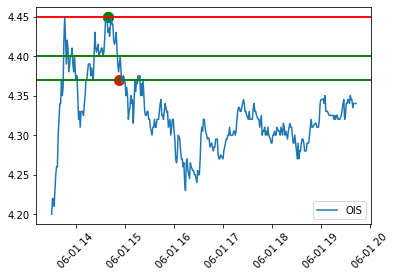

RUTH analysis for run 1271 with profit -99.84


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3394.56,-3394.56,buy,2020-06-01 14:48:05.632762,8.84,[8.61],"[9.13, 9.14]",384,"{'avg': 8.5321, 'rsi': 69.19146178232174, 'macd': [0.042553814203301954, 0.045297464213003735, 0.05070405650877596, 0.05377983045550572, 0.054779028499746474], 'vwap': 8.84, 'supports': [8.42, 8.48, 8.61], 'sell_macd': [0.024651449834692585, 0.02643415036997787, 0.029937109873188206, 0.03189867429292015, 0.032493417031766114], 'slow macd': [0.05366808018835201, 0.054416878694327764, 0.055775262479802024, 0.0568190609765864, 0.05752857880833062], 'macd_signal': [0.03659046181098481, 0.038331862291388595, 0.040806301134866066, 0.043401006998994, 0.04567661129914449], 'resistances': [9.13, 9.14], 'position_ratio': '1.26', 'sell_macd_signal': [0.02057470515546659, 0.021746594198368847, 0.02338469733333272, 0.025087492725250203, 0.026568677586553385]}",9.62,8.58
1,-99.84,3294.72,sell,2020-06-01 18:22:04.568695,8.58,None,None,384,"{'avg': 8.6334, 'rsi': [34.81018694786726, 33.014965656296894], 'vwap': 8.58, 'reasons': 'stopped', 'movement': -0.029411764705882328, 'sell_macd': [-0.014264039302400278, -0.01449382193061588, -0.013601524992463254, -0.014288027053741104, -0.01515688545143945], 'sell_macd_signal': [-0.014543159509248043, -0.01453329199352161, -0.01434693859330994, -0.014335156285396172, -0.014499502118604828]}",9.62,8.58


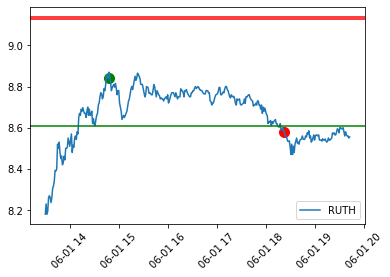

NCR analysis for run 1271 with profit 36.04


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4119.16,-4119.16,buy,2020-06-01 14:28:41.030832,19.43,"[17.95, 19.03]","[20.01, 20.13]",212,"{'avg': 18.9635, 'rsi': 68.40630054160245, 'macd': [0.08201151527538642, 0.07902531907901889, 0.07937487682740141, 0.08432823544134749, 0.09043894962103494], 'vwap': 19.4491, 'supports': [17.95, 18.0, 18.04, 18.3277, 19.03], 'sell_macd': [0.0425962547071137, 0.04093761746601743, 0.0414511778305382, 0.04494939138950471, 0.04916943583299371], 'slow macd': [0.14342500864894348, 0.1424345668932645, 0.1420152367263725, 0.14252185821341, 0.14339976649362285], 'macd_signal': [0.09790955953033846, 0.09413271144007454, 0.09118114451753992, 0.08981056270230144, 0.08993624008604814], 'resistances': [20.13], 'position_ratio': '1.62', 'sell_macd_signal': [0.05202063866121358, 0.04980403442217435, 0.04813346310384712, 0.04749664876097864, 0.047831206175381655]}",20.86,18.98
1,36.04,4155.20,sell,2020-06-01 16:52:04.178805,19.60,None,None,212,"{'avg': 19.1354, 'rsi': [52.47880406152531, 57.28826046006097], 'vwap': 19.61, 'reasons': 'bail', 'movement': 0.009264024704065864, 'sell_macd': [0.012147941325476808, 0.011591605379635439, 0.011786777300024198, 0.010227342727596067, 0.009918337311063397], 'sell_macd_signal': [0.008821744831962536, 0.009375716941497117, 0.009857929013202534, 0.009931811756081241, 0.009929116867077672]}",20.86,18.98


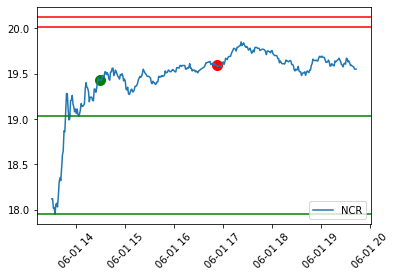

GES analysis for run 1271 with profit -99.82


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3294.06,-3294.06,buy,2020-06-01 14:15:00.390970,10.23,[9.99],"[10.59, 10.62, 10.75]",322,"{'avg': 9.887, 'rsi': 69.63661503587862, 'macd': [0.05756771516375103, 0.05935210833072624, 0.06406236385094033, 0.06660786474169456, 0.07304427866189478], 'vwap': 10.2333, 'supports': [9.309, 9.53, 9.68, 9.75, 9.99], 'sell_macd': [0.03071722657571918, 0.03196346593527544, 0.035116854190315294, 0.03684784693203014, 0.04110514196541892], 'slow macd': [0.062198575105346876, 0.06331056535160684, 0.06503205567357284, 0.06642870541693568, 0.06865020731130222], 'macd_signal': [0.08025217059870768, 0.0760721581451114, 0.07367019928627719, 0.07225773237736066, 0.07241504163426749], 'resistances': [10.75], 'position_ratio': '2.04', 'sell_macd_signal': [0.04595899641990399, 0.043159890322978275, 0.04155128309644568, 0.04061059586356257, 0.04070950508393384]}",11.17,9.93
1,-99.82,3194.24,sell,2020-06-01 14:30:23.175609,9.92,None,None,322,"{'avg': 9.9152, 'rsi': [36.418787862266825, 34.42779101666547], 'vwap': 9.93, 'reasons': 'stopped', 'movement': -0.029325513196481006, 'sell_macd': [-0.0037543725459574517, -0.009306491902457026, -0.013885981116580126, -0.017419531398799037, -0.020985680561583564], 'sell_macd_signal': [0.014780891035250428, 0.009963414447708936, 0.005193535334851123, 0.0006709219881210907, -0.0036603985218198404]}",11.17,9.93


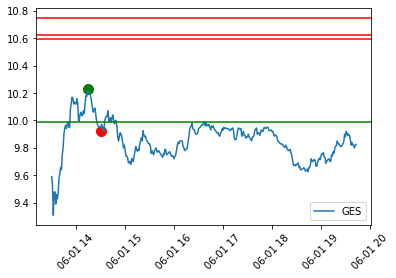

PLYA analysis for run 1272 with profit 55.83


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2365.98,-2365.98,buy,2020-06-01 14:13:10.370765,2.82,"[2.5, 2.55, 2.55, 2.72, 2.73]","[2.82, 2.82]",839,"{'avg': 2.7267, 'rsi': 68.7445400310781, 'macd': [0.014243040710372412, 0.016235857148914512, 0.01792326766744301, 0.019838779980621002, 0.02342684484159374], 'vwap': 2.8285, 'supports': [2.5349, 2.55, 2.56, 2.57, 2.58, 2.58, 2.59, 2.72, 2.73], 'sell_macd': [0.00740695751562459, 0.00875008611782846, 0.00988563975437895, 0.011161582331504327, 0.013517361192491695], 'slow macd': [0.023358312695382466, 0.023730656432254804, 0.024097645761648412, 0.024556682892351578, 0.02540355122748883], 'macd_signal': [0.01755389519722591, 0.01729028758756363, 0.017416883603539508, 0.017901262878955805, 0.01900637927148339], 'resistances': [2.9099], 'position_ratio': '0.82', 'sell_macd_signal': [0.009471859858883911, 0.009327505110672821, 0.009439132039414048, 0.009783622097832104, 0.010530369916764022]}",3.19,2.71
1,-1846.51,519.47,sell,2020-06-01 14:26:19.887661,2.87,None,None,181,"{'avg': 2.7446, 'rsi': [63.86225864232984, 68.05553609899995], 'vwap': 2.871, 'reasons': 'scale-out', 'movement': 0.01950354609929084, 'sell_macd': [0.013583345970429761, 0.013882624973156954, 0.01371215893666955, 0.014180469051917388, 0.015659925387800033], 'sell_macd_signal': [0.01400476291041558, 0.013980335322963855, 0.013926700045704994, 0.013977453846947473, 0.014313948155117984]}",3.19,2.71
2,-1163.45,683.06,sell,2020-06-01 14:26:20.165981,2.87,None,None,238,"{'avg': 2.7446, 'rsi': [63.86225864232984, 68.05553609899995], 'vwap': 2.871, 'reasons': 'scale-out', 'movement': 0.01950354609929084, 'sell_macd': [0.013583345970429761, 0.013882624973156954, 0.01371215893666955, 0.014180469051917388, 0.015659925387800033], 'sell_macd_signal': [0.01400476291041558, 0.013980335322963855, 0.013926700045704994, 0.013977453846947473, 0.014313948155117984]}",3.19,2.71
3,-556.55,606.90,sell,2020-06-01 15:53:19.057722,2.89,None,None,210,"{'avg': 2.7835, 'rsi': [69.8936847285485, 72.44758623776255], 'vwap': 2.89, 'reasons': 'scale-out', 'movement': 0.0069686411149825845, 'sell_macd': [0.0005781088715584026, 0.002358504498892078, 0.00397493609812738, 0.005702351161192443, 0.007493812883565543], 'sell_macd_signal': [0.00042768311753435464, 0.0008138473938058993, 0.0014460651346701954, 0.002297322339974645, 0.0033366204486928244]}",3.19,2.71
4,-251.00,305.55,sell,2020-06-01 16:03:33.575804,2.91,None,None,105,"{'avg': 2.7906, 'rsi': [63.890612058404436, 67.38348797623726], 'vwap': 2.9044, 'reasons': 'scale-out', 'movement': 0.0034602076124566734, 'sell_macd': [0.011131054325174361, 0.011200776945330837, 0.010849901364344383, 0.01043558401079192, 0.010496692774117022], 'sell_macd_signal': [0.008322981933474057, 0.008898540935845413, 0.009288813021545207, 0.009518167219394549, 0.009713872330339043]}",3.19,2.71
5,-99.16,151.84,sell,2020-06-01 16:03:56.718636,2.92,None,None,52,"{'avg': 2.7908, 'rsi': [63.890612058404436, 72.67064703688007], 'vwap': 2.9188, 'reasons': 'scale-out', 'movement': 0.0034364261168384146, 'sell_macd': [0.011131054325174361, 0.011200776945330837, 0.010849901364344383, 0.01043558401079192, 0.011535653813078639], 'sell_macd_signal': [0.008322981933474057, 0.008898540935845413, 0.009288813021545207, 0.009518167219394549, 0.009921664538131366]}",3.19,2.71
6,-23.24,75.92,sell,2020-06-01 16:04:02.128878,2.92,None,None,26,"{'avg': 2.7912, 'rsi': [63.890612058404436, 72.67064703688007], 'vwap': 2.92, 'reasons': 'scale-out', 'movement': 0.0, 'sell_macd': [0.011131054325174361, 0.011200776945330837, 0.010849901364344383, 0.01043558401079192, 0.011535653813078639], 'sell_macd_signal': [0.008322981933474057, 0.008898540935845413, 0.009288813021545207, 0.009518167219394549, 0.009921664538131366]}",3.19,2.71
7,14.85,38.09,sell,2020-06-01 16:05:24.174613,2.93,None,None,13,"{'avg': 2.7921, 'rsi': [74.71962975036556, 74.71962975036556], 'vwap': 2.93, 'reasons': 'scale-out', 'moveme

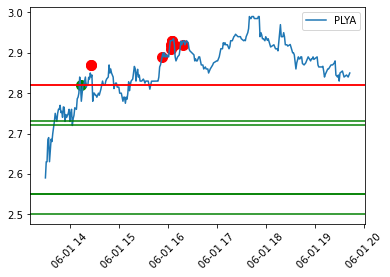

HT analysis for run 1272 with profit 20.0


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-5440.0,-5440.0,buy,2020-06-01 14:36:21.866786,5.44,[5.38],"[5.52, 5.53, 5.54, 5.55, 5.56]",1000,"{'avg': 5.2655, 'rsi': 69.92845774128426, 'macd': [0.022287614163362335, 0.021731823918752724, 0.021048719608374178, 0.022666814868238738, 0.025271683634592534], 'vwap': 5.434, 'supports': [5.01, 5.03, 5.285, 5.355, 5.38], 'sell_macd': [0.012045201146679396, 0.011729349994948457, 0.011330902993665681, 0.012431711784955723, 0.014166995105637348], 'slow macd': [0.03378927138350729, 0.03368702688392755, 0.033539080981860536, 0.03382913302321011, 0.034361757259536496], 'macd_signal': [0.02504447255336097, 0.02438194282643932, 0.02371529818282629, 0.02350560151990878, 0.02385881794284553], 'resistances': [5.52, 5.54, 5.55, 5.56], 'position_ratio': '1.33', 'sell_macd_signal': [0.01368718126719504, 0.013295615012745723, 0.012902672608929714, 0.012808480444134917, 0.013080183376435402]}",5.74,5.34
1,20.0,5460.0,sell,2020-06-01 14:49:23.914644,5.46,None,None,1000,"{'avg': 5.3088, 'rsi': [63.44647176051904, 62.04891505193228], 'vwap': 5.468, 'reasons': 'bail', 'movement': 0.005514705882352824, 'sell_macd': [0.017825874786951523, 0.01638038635081962, 0.015041299434992439, 0.015620695352075664, 0.015609566256918228], 'sell_macd_signal': [0.01669596990931512, 0.01663285319761602, 0.016314542445091305, 0.016175773026488177, 0.01606253167257419]}",5.74,5.34


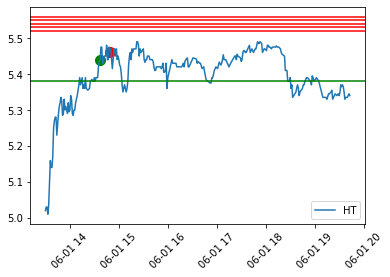

GCO analysis for run 1272 with profit -125.0


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-9580.0,-9580.0,buy,2020-06-01 13:56:20.793470,19.16,"[17.88, 18.33, 19.0]",[19.36],500,"{'avg': 18.3966, 'rsi': 64.36444099791055, 'macd': [0.16861395820416902, 0.1745045256180937, 0.1815184513627024, 0.18733826838354517, 0.19654367182285526], 'vwap': 19.1271, 'supports': [17.88, 18.29, 18.33, 18.45, 18.625, 18.76, 19.0], 'sell_macd': [0.11503927645750522, 0.11784381486999962, 0.12135587318012497, 0.1240749332506148, 0.12899790300358305], 'slow macd': [-0.011420019740846499, -0.004347529480206447, 0.0030459891953853457, 0.010323199317639364, 0.0183614111105328], 'macd_signal': [0.03625541214284645, 0.0639052348378959, 0.0874278781428572, 0.10740995619099479, 0.1252366993173669], 'resistances': [19.36], 'position_ratio': '1.12', 'sell_macd_signal': [0.030004799492778143, 0.04757260256822243, 0.06232925669060294, 0.07467839200260531, 0.08554229420280086]}",19.77,18.97
1,-125.0,9455.0,sell,2020-06-01 14:04:10.069949,18.91,None,None,500,"{'avg': 18.4678, 'rsi': [56.8595239174862, 55.35112940254179], 'vwap': 18.95, 'reasons': 'stopped', 'movement': -0.010960334029227602, 'sell_macd': [0.11374241487948211, 0.10789480822834818, 0.09985907826346008, 0.09126163831337308, 0.08181867681572896], 'sell_macd_signal': [0.10147146780762079, 0.10275613589176627, 0.10217672436610503, 0.09999370715555864, 0.0963587010875927]}",19.77,18.97


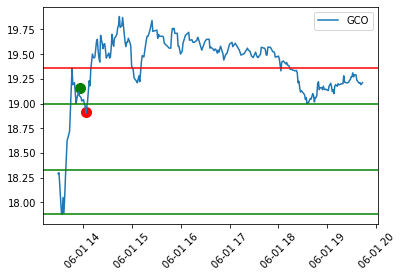

In [14]:
for batch_id, count in batch.items():
    for run_id in batch[batch_id]:
        for symbol in minute_history:    
            if symbol not in trade_details[run_id]:
                continue
            start_date = datetime.strptime(start_day_to_analyze, "%Y-%m-%d") + timedelta(hours=9, minutes=30)
            minute_history_index = minute_history[symbol]["close"].index.get_loc(start_date, method='nearest')
            plt.plot(minute_history[symbol]["close"][minute_history_index:].between_time("9:30", "16:00"), label=symbol)
            plt.xticks(rotation=45)
            delta = 0
            profit = 0

            operations = []
            deltas = []
            profits = []
            times = []
            prices = []
            qtys = []
            indicators = []
            target_price = []
            stop_price = []
            resistances = []
            supports = []
            for trade in trade_details[run_id][symbol]:
                resistance = None
                support = None
                if trade[0] == 'buy':
                    resistance = find_resistance(trade[2], minute_history[symbol], trade[1])

                    for r in resistance:
                        plt.axhline(y=r, color="r")
                    support = find_support(trade[2], minute_history[symbol], trade[1])
                    for s in support:
                        plt.axhline(y=s, color="g")  

                delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
                profit += delta
                plt.scatter(pd.to_datetime(trade[1]), trade[2], c='g' if trade[0] == 'buy' or trade[0] == 'sell_short' else 'r', s=100)
                deltas.append(round(delta, 2))
                profits.append(round(profit, 2))
                operations.append(trade[0])
                times.append(pd.to_datetime(trade[1]))
                prices.append(trade[2])
                qtys.append(trade[3])
                indicators.append(trade[4])
                target_price.append(trade[6])
                stop_price.append(trade[5])    
                resistances.append(resistance)
                supports.append(support)
            d = {
                'profit': profits,
                'trade': deltas,
                'operation': operations,
                'at': times,
                'price': prices,
                'support': supports,
                'resistance': resistances,
                'qty': qtys,
                'indicators': indicators,
                'target price': target_price,
                'stop price': stop_price
            }   
            print (f'{symbol} analysis for run {run_id} with profit {round(profit, 2)}')
            display(HTML(pd.DataFrame(data=d).to_html()))
            plt.legend()
            plt.show()

In [ ]:
 pd.Timestamp('2020-04-16 13:44:06.066') 

In [ ]:
index = minute_history['NURO'].index.get_loc(pd.Timestamp('2020-04-16 13:44:06.066') , method='nearest')

In [ ]:
minute_history['NURO'][:index]

In [ ]:
series = minute_history['NURO'][:2417]['close']

In [ ]:
MACD(series.dropna().between_time("9:30", "16:00"))